# Barcode and small chunk alignments

In [1]:
import lzma
import time
from contextlib import contextmanager, redirect_stdout
from io import StringIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from pybasecall_client_lib import helper_functions
from pybasecall_client_lib.helper_functions import (
    basecall_with_pybasecall_client,
    run_server,
)
from pybasecall_client_lib.pyclient import PyBasecallClient
from readpaf import parse_paf

/home/adoni5/mambaforge/envs/jupyter-lab/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.style.use("../figures.mplstyle")

## Download reference if it's not there already


In [3]:
output_file = Path("HG38_without_alts.fna.gz")


def download_hg38_without_alts():
    url = "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.40_GRCh38.p14/GRCh38_major_release_seqs_for_alignment_pipelines/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz"

    response = requests.get(url, stream=True)
    total_length = int(response.headers.get("content-length", 0))
    if response.status_code == 200:
        with open(output_file, "wb") as file, alive_bar(
            total_length,
            bar="blocks",
            length=40,
            title="Downloading HG38",
            force_tty=True,
        ) as bar:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
                    bar(len(chunk))
        print(f"Download completed: {output_file}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")


if not output_file.exists():
    import requests
    from alive_progress import alive_bar

    download_hg38_without_alts()

## Basecall and align the pod 5 files

In [ ]:
search_dir = Path("chunking_code/")
configs = ["dna_r10.4.1_e8.2_400bps_5khz_fast.cfg"]
BIN_PATH = "/usr/bin/"


def pack(read: dict[str, str | npt.NDArray[np.int16]]):
    """Pack an ont_fast5_api.Fast5Read for calling
    passed dict has two fields, read_id and raw_Data
    read_id: str, raw_data: npt.NDArray[np.int16]
    """
    read_id = read["read_id"]
    raw_data = read["raw_data"]
    scaling = RANGE / DIGITISATION
    offset = 0.0
    return helper_functions.package_read(read_id, raw_data, offset, scaling)


@contextmanager
def start_guppy_server_and_client(
    bin_path: str,
    config: str,
    address: str = "ipc:///tmp/.guppy/5555",
    server_args: list[str] = [],
    client_args: dict[str:str] = {},
) -> None:
    server_args.extend(
        [
            "--config",
            config,
            "--port",
            address,
            "--log_path",
            str((Path(".") / "junk")),
            "--device",
            "cuda:all",
        ]
    )
    # This function has it's own prints that may want to be suppressed
    with redirect_stdout(StringIO()) as fh:
        server, port = run_server(server_args, bin_path=bin_path)

    if port == "ERROR":
        raise RuntimeError("Server couldn't be started")

    if address.startswith("ipc"):
        address = f"{port}"
    else:
        address = f"localhost:{port}"
    client = PyBasecallClient(address=address, config=config, **client_args)
    client.connect()

    try:
        with client:
            yield client
    finally:
        print("Rip server")
        server.terminate()


# configs = ["dna_r10.4.1_e8.2_400bps_5khz_fast", "dna_r10.4.1_e8.2_400bps_5khz_hac", "dna_r10.4.1_e8.2_400bps_5khz_sup"]
for config in configs:
    with start_guppy_server_and_client(
        BIN_PATH, config, client_args={"align_ref": "HG38_without_alts.fna.gz"}
    ) as client:
        for pod5 in filter(
            lambda x: x.is_dir(),
            search_dir.iterdir(),
        ):
            print(pod5)
            # time.sleep(10)
            called_reads = basecall_with_pybasecall_client(client, pod5)
            for read in called_reads:
                print("hello")

[ont/error] basecall_client::Client::worker_loop: Connection error. [timed_out] Failed to establish connection with address: ipc:///tmp/.guppy/5555
[ont/error] basecall_client::Client::worker_loop: Connection error. [timed_out] Failed to establish connection with address: ipc:///tmp/.guppy/5555


## Compress the PAF files

### Read in "Truth" Paf file

In [3]:
test_paf = "figure_1_a_paf_files/2000_supsr_calls.paf.xz"
with lzma.open(test_paf, "rt") as fh:
    try:
        test_paf = parse_paf(fh, dataframe=True)
    except Exception as e:
        print(f"Error reading in paf file - {repr(e)}")

In [4]:
test_paf["query_length"].describe()

count    25708.000000
mean       179.047184
std         35.393829
min         10.000000
25%        160.000000
50%        181.000000
75%        201.000000
max        318.000000
Name: query_length, dtype: float64

In [5]:
truth_paf = "figure_1_a_paf_files/original_sup_multi_calls.paf.xz"
with lzma.open(truth_paf, "rt") as fh:
    try:
        truth_paf_df = parse_paf(fh, dataframe=True)
    except Exception as e:
        print(f"Error reading in paf file - {repr(e)}")

truth_paf_df.drop_duplicates(["query_name"], keep="first", inplace=True)

truth_paf_df["map_start"] = np.where(
    truth_paf_df["strand"] == "+",
    truth_paf_df["target_start"],
    truth_paf_df["target_end"],
)

### Loop through the truncated PAF files

#### Calculate precision, recall, F1 for mappings within 100 base of original

In [6]:
result_dict = {}
path_to_paf_files = Path("figure_1_a_paf_files/")
prog = tqdm(list(path_to_paf_files.rglob("*.paf.xz")), dynamic_ncols=True)
# this line should ensure a perfect match between calls
for comp_path in prog:
    prog.set_description(f"Processing {comp_path}")
    with lzma.open(comp_path, "rt") as handle:
        try:
            comp_df = parse_paf(handle, dataframe=True)
        except FileNotFoundError as e:
            print(f"Error loading file {file} -> {repr(e)}")
            break
    comp_path = comp_path.name
    # lose multi mappings
    comp_df.drop_duplicates(["query_name"], keep="first", inplace=True)
    comp_df["map_start"] = pd.to_numeric(
        np.where(
            comp_df["strand"] == "+", comp_df["target_start"], comp_df["target_end"]
        )
    )

    result_all = truth_paf_df.merge(comp_df, on="query_name")
    result_all["same_strand"] = result_all["strand_x"] == result_all["strand_y"]
    result_all["ref_mapped"] = result_all.target_name_x != "*"
    result_all["query_mapped"] = result_all.target_name_y != "*"
    result_all["same_mapped"] = result_all.target_name_x == result_all.target_name_y
    for window in [50]:  # ,100,1000,5000,10000]:
        result_all["within_window"] = (
            abs(result_all.map_start_x.values - result_all.map_start_y.values) <= window
        )

        # True negatives will be:
        result_all["true_negative"] = result_all["target_name_x"].eq("*") & result_all[
            "target_name_y"
        ].eq("*")
        # False negatives will be:
        result_all["false_negative"] = result_all["target_name_x"].ne("*") & result_all[
            "target_name_y"
        ].eq("*")

        # True Positives
        result_all["true_positive"] = (
            result_all["same_mapped"]
            & result_all["target_name_x"].ne("*")
            & result_all["within_window"]
        )

        # False Positives
        result_all["false_positive"] = result_all["query_mapped"] & (
            (result_all.target_name_x != result_all.target_name_y)
            | (
                abs(result_all.map_start_x.values - result_all.map_start_y.values)
                > window
            )
        )

        comparison_dict = {}
        # loop through and get counts for each one to put into the dicitonary
        for result in [
            "true_positive",
            "false_positive",
            "true_negative",
            "false_negative",
        ]:
            comparison_dict[result] = (
                result_all[result].value_counts().to_dict().get(True, 0)
            )
        comparison_dict["total"] = result_all.shape[0]

        # time for some precision
        try:
            precision = comparison_dict["true_positive"] / (
                comparison_dict["true_positive"] + comparison_dict["false_positive"]
            )
        except ZeroDivisionError:
            precision = 0
        comparison_dict["precision"] = precision

        # time for some recall

        comparison_dict["recall"] = comparison_dict["true_positive"] / (
            comparison_dict["true_positive"] + comparison_dict["false_negative"]
        )

        try:
            F1 = (
                2
                * (comparison_dict["precision"] * comparison_dict["recall"])
                / (comparison_dict["precision"] + comparison_dict["recall"])
            )
        except ZeroDivisionError:
            F1 = 0
        # time for some F1
        comparison_dict["F1"] = F1

        result_dict[(comp_path, window)] = comparison_dict

  0%|                                                                                                         …

In [7]:
f1_plot_df = (
    pd.DataFrame(result_dict)
    .T.reset_index()
    .rename(columns={"level_0": "filename", "level_1": "window_width"})
)
f1_plot_df[["read_length", "caller"]] = (
    f1_plot_df["filename"].str.split(pat="_", expand=True).loc[:, 0:1]
)
f1_plot_df["read_length"] = f1_plot_df["read_length"].str.replace(
    ".paf", "", regex=False
)

In [8]:
comp_df

,query_name,query_length,query_start,query_end,strand,target_name,target_length,target_start,target_end,residue_matches,alignment_block_length,mapping_quality,mt,ci,sl,map_start
0,4b5f5c88-31e8-48fd-adc0-251c5ccde7b4,1596,0,0,*,*,0,0,0,0,0,61,0.0,1,1596,0
1,4b60e1dc-7063-45a1-ac73-b3f2ebf26fd2,1595,0,0,*,*,0,0,0,0,0,61,0.0,1,1595,0
2,4b797c52-6557-4ca8-91e0-38604e02dd5c,1597,0,0,*,*,0,0,0,0,0,61,0.0,1,1597,0
3,4b85aaa2-d307-4924-aed0-a2c7f67f28c8,1597,0,0,*,*,0,0,0,0,0,61,0.0,1,1597,0
4,4ba3aeae-516e-4501-8855-7cc88e1654d5,1599,0,0,*,*,0,0,0,0,0,61,0.0,1,1599,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25041,9c322a7e-1198-4718-8e46-a8398d5204ec,1598,0,0,*,*,0,0,0,0,0,61,0.0,1,1598,0
25042,9c3b96fa-8764-44e2-8ad8-54aebea471f4,1599,0,0,*,*,0,0,0,0,0,61,0.0,1,1599,0
25043,9c44092d-2642-4747-92c5-aa08329b29c2,1600,0,0,*,*,0,0,0,0,0,61,0.0,1,1600,0
25044,9c5086cd-5d46-4c41-9ead-3650f15a34e7,1599,0,0,*,*,0,0,0,0,0,61,0.0,1,1599,0


In [9]:
f1_plot_df[
    f1_plot_df["filename"].str.contains("fast") & f1_plot_df["read_length"].eq("2000")
]

,filename,window_width,true_positive,false_positive,true_negative,false_negative,total,precision,recall,F1,read_length,caller
1,2000_rawhashfast_multi_calls.paf.xz,50,418.0,2368.0,4560.0,17700.0,25046.0,0.150036,0.023071,0.039992,2000,rawhashfast
26,2000_fastsr_calls.paf.xz,50,10857.0,2021.0,4789.0,7379.0,25046.0,0.843066,0.595361,0.697885,2000,fastsr
42,2000_rawhashfaster_multi_calls.paf.xz,50,419.0,2365.0,4560.0,17702.0,25046.0,0.150503,0.023122,0.040086,2000,rawhashfaster
149,2000_fast_multi_calls.paf.xz,50,11158.0,390.0,5072.0,8426.0,25046.0,0.966228,0.569751,0.716819,2000,fast


In [10]:
file = "figure_1_b_files/original_hac_seq_sum.txt.xz"

fields = [
    "read_id",
    "barcode_arrangement",
    "barcode_front_id",
    "barcode_rear_id",
    "barcode_front_foundseq",
    "barcode_rear_foundseq",
]

truth_seq_sum_df = pd.read_csv(file, usecols=fields, sep="\t")

In [11]:
barc_results = dict()
pbar1 = tqdm(["sup", "hac", "fast", "sketch"], dynamic_ncols=True)
for model in pbar1:
    pbar1.set_description(f"{model=}")
    barc_results[model] = dict()
    for length in [
        "original",
        "800",
        "1200",
        "1600",
        "2000",
        "2400",
        "2800",
        "3200",
        "3600",
        "4000",
        "5000",
        "6000",
        "7000",
        "8000",
        "9000",
        "10000",
    ]:
        file = "figure_1_b_files/{}_{}_seq_sum.txt.xz".format(length, model)
        fields = [
            "read_id",
            "barcode_arrangement",
            "barcode_front_id",
            "barcode_rear_id",
            "barcode_front_foundseq",
            "barcode_rear_foundseq",
        ]
        sup_seq_sum_df = pd.read_csv(file, usecols=fields, sep="\t")
        barc_all = truth_seq_sum_df.merge(sup_seq_sum_df, on="read_id", how="left")
        barc_all["same"] = np.where(
            barc_all["barcode_arrangement_x"] == barc_all["barcode_arrangement_y"], 1, 0
        )
        tn = len(
            barc_all[
                barc_all["same"].eq(1)
                & barc_all["barcode_arrangement_x"].eq("unclassified")
            ]
        )
        tp = len(
            barc_all[
                barc_all["same"].eq(1)
                & ~barc_all["barcode_arrangement_x"].eq("unclassified")
            ]
        )
        fn = len(
            barc_all[
                ~barc_all["barcode_arrangement_x"].eq("unclassified")
                & barc_all["barcode_arrangement_y"].eq("unclassified")
            ]
        )
        fp = len(
            barc_all[
                barc_all["barcode_arrangement_x"].eq("unclassified")
                & ~barc_all["barcode_arrangement_y"].eq("unclassified")
            ]
        )
        # print (tn,tp,fn,fp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        # print (precision, recall, f1)
        barc_results[model][length] = dict()
        barc_results[model][length]["precision"] = precision
        barc_results[model][length]["recall"] = recall
        barc_results[model][length]["f1"] = f1

  0%|                                                                                                         …

In [12]:
barcs = pd.concat({k: pd.DataFrame(v).T for k, v in barc_results.items()}, axis=0)
barcs.reset_index(inplace=True)
barcs = barcs.rename(columns={"level_0": "caller", "level_1": "length"})

In [13]:
f1_plot_df[
    f1_plot_df["window_width"].eq(1000) & f1_plot_df["filename"].str.contains("rawhash")
]

,filename,window_width,true_positive,false_positive,true_negative,false_negative,total,precision,recall,F1,read_length,caller


Text(-0.1, 0.98, 'C')

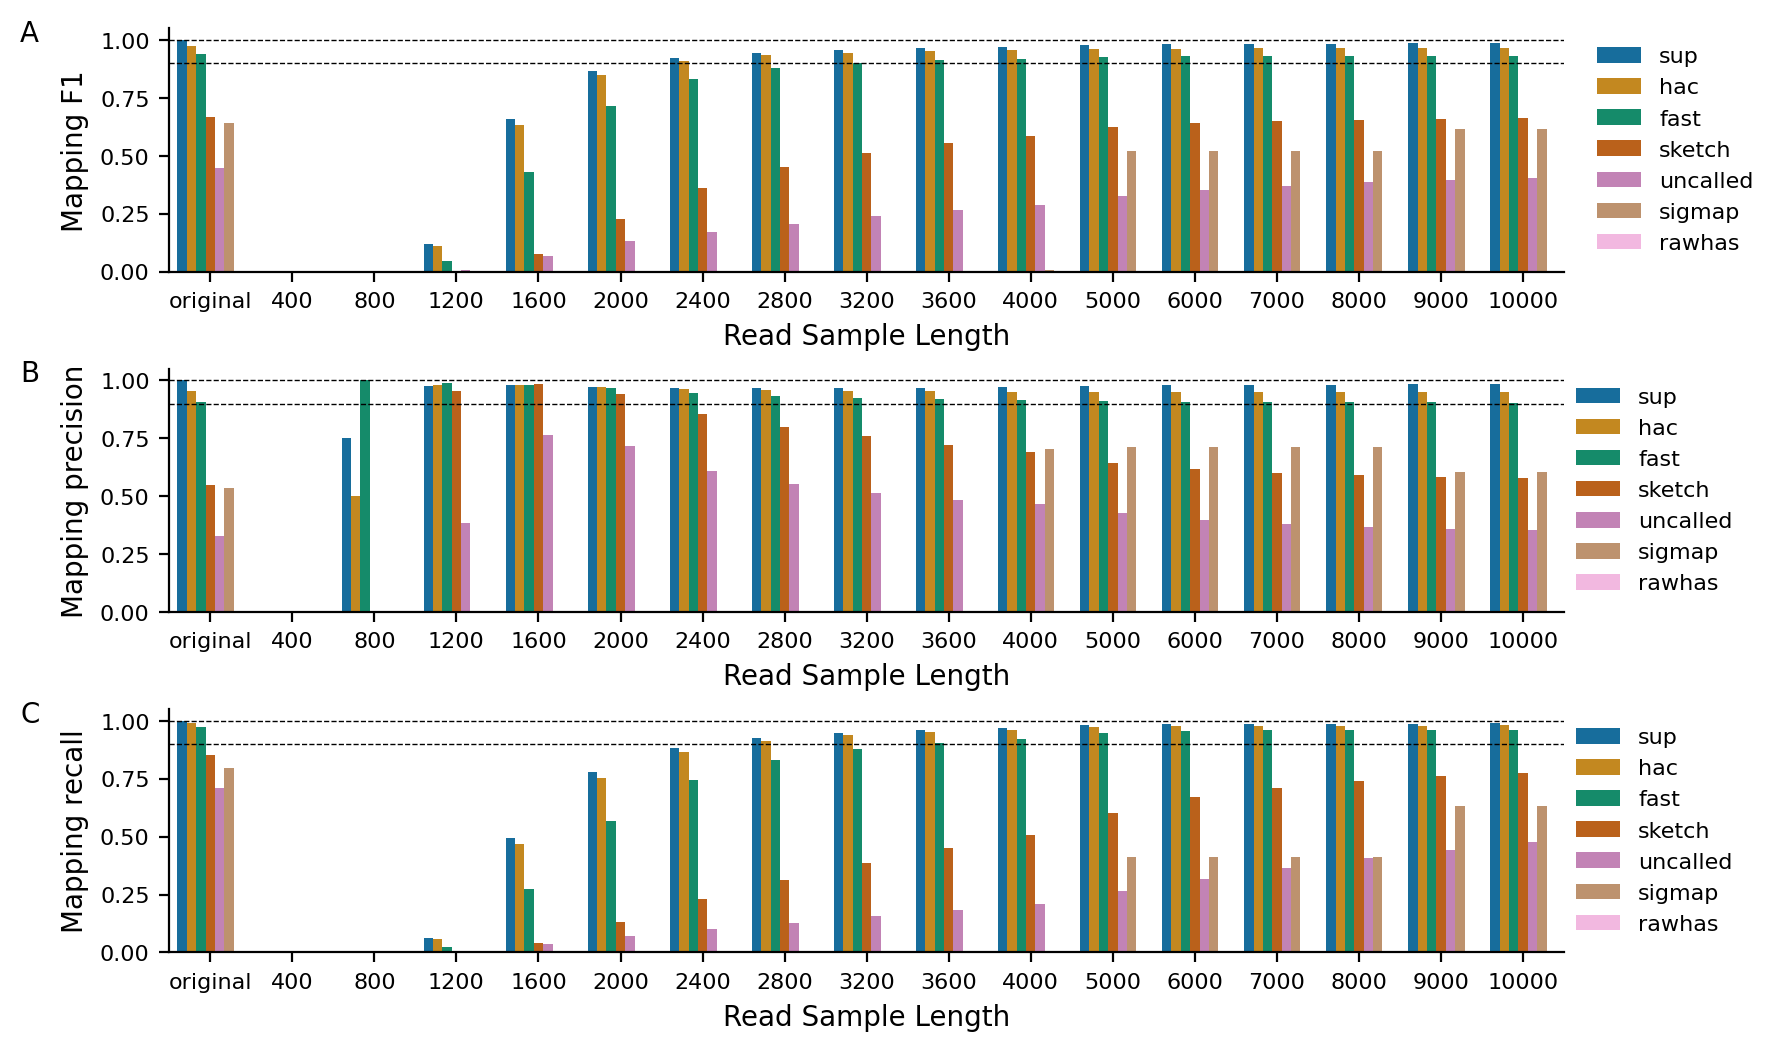

In [20]:
temp = f1_plot_df[f1_plot_df["window_width"].eq(50)]
# sample_list = ["sup", "supsr","hac","hacsr", "fast","fastsr", "sketch","sketchsr", "rawhashsensitive","rawhashfast","rawhashfaster","rawhash", "uncalled", "sigmap"]
# sample_list = ["sup", "supsr","hac","hacsr", "fast","fastsr", "sketch","sketchsr"]
sample_list = ["sup", "hac", "fast", "sketch", "uncalled", "sigmap", "rawhas"]
# sample_list = ["sup", "supsr","fast","fastsr"]

shared_kws = {
    "order": ["original"]
    + list(map(str, range(400, 4000, 400)))
    + list(map(str, range(4000, 10001, 1000))),
    "palette": "colorblind",
}
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 6), gridspec_kw={"hspace": 0.4})
sns.barplot(
    ax=ax1,
    x="read_length",
    y="F1",
    hue="caller",
    # data=f1_plot_df[f1_plot_df['window_width'].eq(1000)],
    data=temp,
    ci=None,
    hue_order=sample_list,
    **shared_kws,
)

ax1.set(ylabel="Mapping F1")
ax1.set(xlabel="Read Sample Length")
ax1.axhline(0.9, lw=0.5, ls="--", c="k")
ax1.axhline(1.0, lw=0.5, ls="--", c="k")
sns.move_legend(
    ax1,
    loc="center right",
    bbox_to_anchor=(1.15, 0.5),
    fontsize=8,
    frameon=False,
    title=None,
)

ax1.text(
    -0.1,
    0.98,
    "A",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax1.transAxes,
)

sns.barplot(
    ax=ax2,
    x="read_length",
    y="precision",
    hue="caller",
    data=temp,
    # data=f1_plot_df,
    ci=None,
    hue_order=sample_list,
    **shared_kws,
)

ax2.set(ylabel="Mapping precision")
ax2.set(xlabel="Read Sample Length")
ax2.axhline(0.9, lw=0.5, ls="--", c="k")
ax2.axhline(1.0, lw=0.5, ls="--", c="k")

sns.move_legend(
    ax2,
    loc="center right",
    bbox_to_anchor=(1.135, 0.5),
    fontsize=8,
    frameon=False,
    title=None,
)

ax2.text(
    -0.1,
    0.98,
    "B",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax2.transAxes,
)

sns.barplot(
    ax=ax3,
    x="read_length",
    y="recall",
    hue="caller",
    data=temp,
    # data=f1_plot_df,
    ci=None,
    hue_order=sample_list,
    **shared_kws,
)

ax3.set(ylabel="Mapping recall")
ax3.set(xlabel="Read Sample Length")

ax3.axhline(0.9, lw=0.5, ls="--", c="k")
ax3.axhline(1.0, lw=0.5, ls="--", c="k")

sns.move_legend(
    ax3,
    loc="center right",
    bbox_to_anchor=(1.135, 0.5),
    fontsize=8,
    frameon=False,
    title=None,
)

ax3.text(
    -0.1,
    0.98,
    "C",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax3.transAxes,
)

# Plot B
# sns.barplot(
#     ax=ax2,
#     x="length",
#     y="f1",
#     hue="caller",
#     data=barcs,
#     hue_order=["sup", "hac", "fast", "sketch"],
#     **shared_kws,
# )
# ax2.axhline(0.9, lw=0.5, ls="--", c="k")
# ax2.set(ylabel="Barcode F1")
# ax2.set(xlabel="Read Sample Length")

# sns.move_legend(
#     ax2,
#     loc="center right",
#     bbox_to_anchor=(1.135, 0.5),
#     fontsize=8,
#     frameon=False,
#     title=None,
# )

# ax2.text(
#     -0.1,
#     0.98,
#     "B",
#     horizontalalignment="center",
#     verticalalignment="center",
#     transform=ax2.transAxes,
# )

# fig.savefig("figure_1.pdf", bbox_inches="tight")